In [ ]:
!pip install -q tensorflow_datasets
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
tfds.disable_progress_bar()

In [ ]:
#讀取資料
#使用TFDS(Google開源數據集)來下載IMDB資料，這個二元分類資料裡面有正負情緒資料
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteUWSN0N/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteUWSN0N/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteUWSN0N/imdb_reviews-unsupervised.tfrecord
Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
#採用tf.data做資料儲存，可以比一般的傳遞方式快12倍，在TPU上更能快27倍的速度

In [ ]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 11,   7,  29, ...,   0,   0,   0],
       [ 10, 249,  11, ...,   0,   0,   0],
       [ 45,   2,   1, ...,   0,   0,   0]])

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()),64, mask_zero=True),  #第一層一樣先做Embedding，效果比One-hot效果好
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)), #透過一層RNN來包一個LSTM，其中64為單位的維度
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), #透過一層RNN來包一個LSTM，其中32為單位的維度
    tf.keras.layers.Dense(64, activation='relu'),#做一層Relu，讓數據範圍控制在Relu範圍
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)#再做一層sigmoid做機率輸出
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 79s 148ms/step - loss: 0.5542 - accuracy: 0.6611 - val_loss: 0.3917 - val_accuracy: 0.8391
Epoch 2/10
391/391 [==============================] - 55s 139ms/step - loss: 0.3665 - accuracy: 0.8415 - val_loss: 0.3636 - val_accuracy: 0.8458
Epoch 3/10
391/391 [==============================] - 55s 139ms/step - loss: 0.3628 - accuracy: 0.8431 - val_loss: 0.3825 - val_accuracy: 0.8240
Epoch 4/10
391/391 [==============================] - 55s 139ms/step - loss: 0.3525 - accuracy: 0.8421 - val_loss: 0.3371 - val_accuracy: 0.8323
Epoch 5/10
391/391 [==============================] - 55s 140ms/step - loss: 0.3054 - accuracy: 0.8669 - val_loss: 0.3316 - val_accuracy: 0.8448
Epoch 6/10
391/391 [==============================] - 55s 141ms/step - loss: 0.2999 - accuracy: 0.8704 - val_loss: 0.3222 - val_accuracy: 0.8531
Epoch 7/10
391/391 [==============================] - 55s 140ms/step - loss: 0.2806 - accuracy: 0.8819 - val_loss: 0.3223 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 27s 69ms/step - loss: 0.3194 - accuracy: 0.8681
Test Loss: 0.31939902901649475
Test Accuracy: 0.8680800199508667


In [ ]:
sample_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

#0以上為正面，0以下負面

[[-4.7043266]]


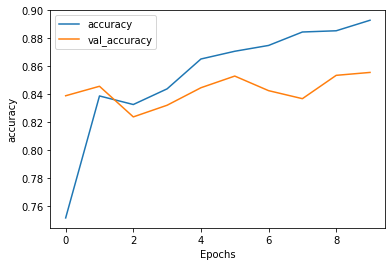

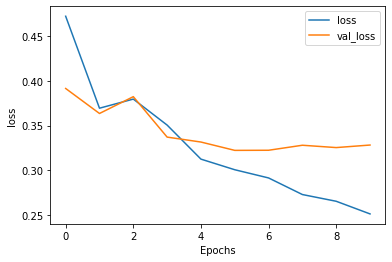

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()